## Data Preparation

### Getting data from Alpha Vantage

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np

from alpha_vantage.timeseries import TimeSeries


config = {
    "alpha_vantage": {
        "key": "6IN7ZPN5592V62VK", # API key
        "symbol": "SPY",
        "outputsize": "full", # full 20+ years
        "key_adjusted_close": "4. close", # adjusted close price for splits/dividends
    },
    "data": {
        "window_size": 20, # use information from past 20 days to predict
        "train_split_size": 0.80,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # we are only using 1 feature: close price
        "num_lstm_layers": 2,
        "lstm_size": 32, # hidden state dimensionality
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu",
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40, # lr scheduler interval
    }
}

def download_data(config):
    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily(symbol=config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"]) # type: ignore

    data_dates = [date for date in data.keys()] # type: ignore
    # print(data_dates[:5])
    # print(data_dates[-5:])
    # dates is in order of recent -> old
    data_dates.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data_dates]
    # print(data_close_price[:5], data_close_price[-5:])    
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_dates)
    display_date_range = f"from {data_dates[0]} to {data_dates[-1]}"
    print("Number of data points:", num_data_points, display_date_range)

    return data_dates, data_close_price, num_data_points, display_date_range


def plot_data(data_dates, data_close_price, num_data_points, display_date_range):
    fig = plt.figure(figsize=(25, 5), dpi=100)
    fig.patch.set_facecolor(color="white")
    plt.plot(data_dates, data_close_price, color=config["plots"]["color_actual"])

    xticks_labels = []
    xticks_interval = config["plots"]["xticks_interval"]

    for i in range(num_data_points):
        # Always include the last data point
        if i == num_data_points - 1:
            xticks_labels.append(data_dates[i])
        # Include every xticks_interval-th point, but avoid ticks too close to the end
        elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
            xticks_labels.append(data_dates[i])
        else:
            xticks_labels.append(None)

    xticks_indices = np.arange(0, len(xticks_labels))
    plt.xticks(xticks_indices, xticks_labels, rotation="vertical")

    plt.title(f"Daily close price for {config["alpha_vantage"]["symbol"]}, {display_date_range}")
    plt.grid(axis="y", linestyle="--")


data_dates, data_close_price, num_data_points, display_date_range = download_data(config)

Number of data points: 6489 from 1999-11-01 to 2025-08-19


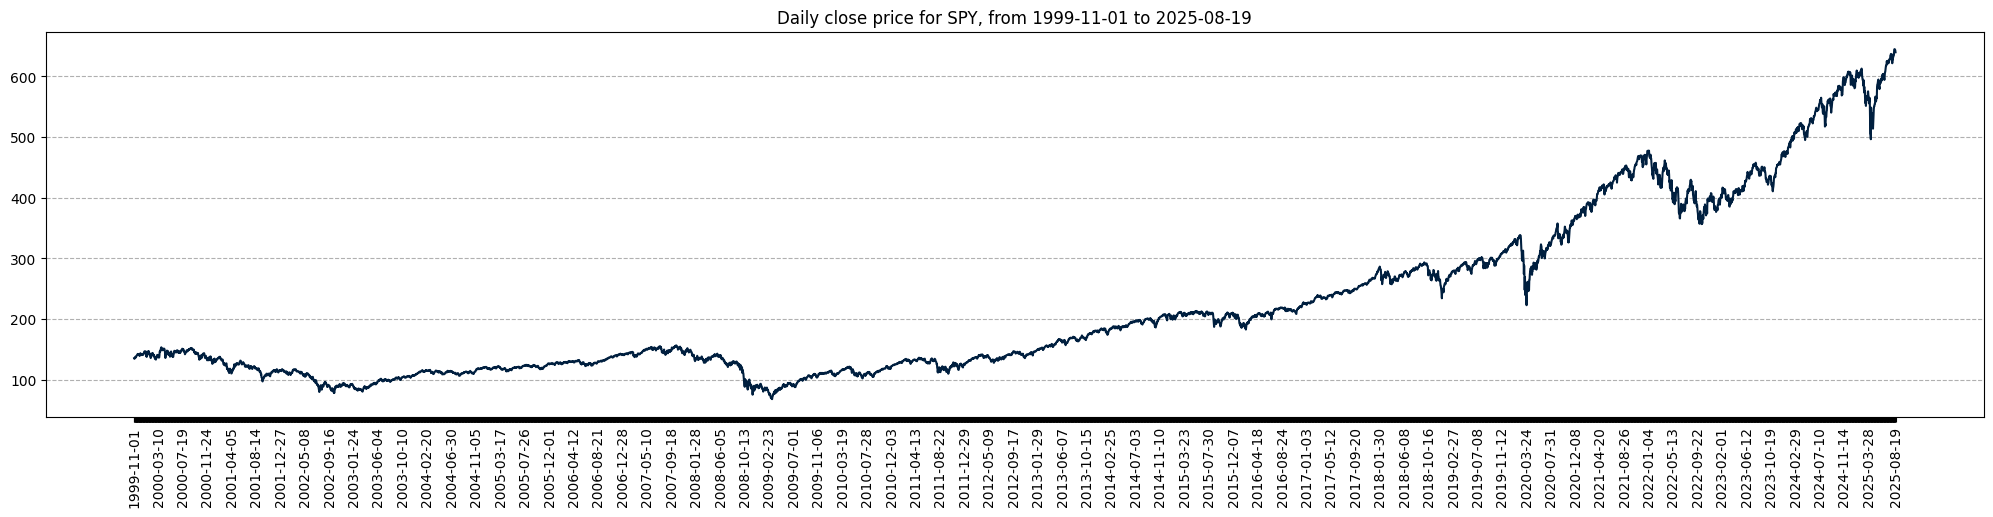

In [15]:
plot_data(data_dates, data_close_price, num_data_points, display_date_range)

### Normalizing raw data

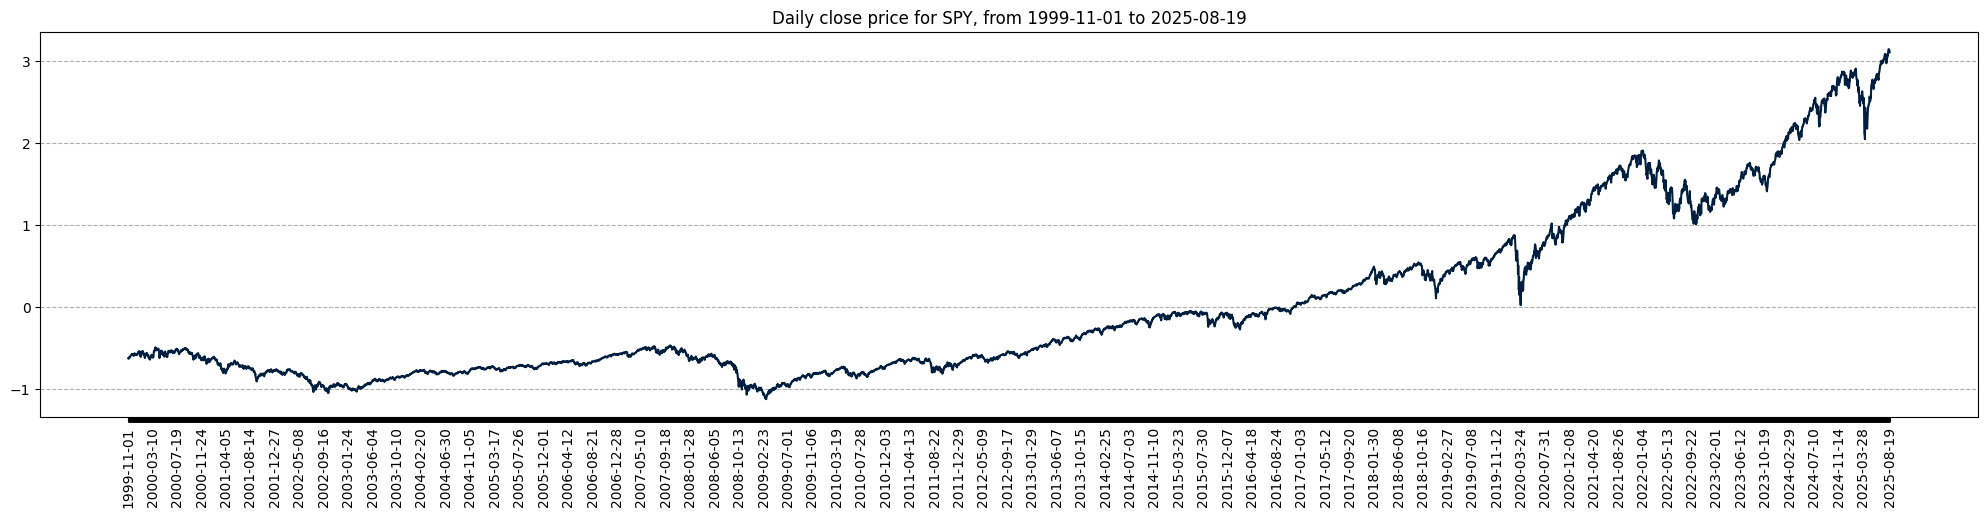

In [13]:
# use standardization
class Normalizer():
    def __init__(self):
        self.mean = None
        self.sd = None

    def standardize(self, data):
        self.mean = np.mean(data, axis=0, keepdims=True)
        self.std = np.std(data, axis=0, keepdims=True)
        return (data - self.mean) / self.std
    
    def inverse_transform(self, data):
        return data * self.std  + self.mean
    
scaler = Normalizer()
normalized_data_close_price = scaler.standardize(data_close_price)
plot_data(data_dates, normalized_data_close_price, num_data_points, display_date_range)

### Train/Val split

In [ ]:
np.lib.stride_tricks.as_strided()